In [14]:
%matplotlib notebook

In [1]:
import sys
sys.path.append("../cv-tfq")

from qdhmc_wfplot import HMC
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

from cv_utils import domain_float

2022-08-29 16:23:23.778468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-08-29 16:23:23.778503: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/peter/.local/lib/python3.8/site-packages/cirq/ops/gateset.py:376: UserWarning: v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If you were relying on this behavior, you can include a `cirq.GlobalPhaseGate` in your `*gates`. If not, then you can ignore this warning. It will be removed in v0.16
  warnings.warn(
2022-08-29 16:23:25.957916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-

In [2]:
def guassian_log_prob(n, temp):
    def lp(x):
        return np.sum([-1 * x[i] for i in range(n)] + [-1 * x[i]**2 for i in range(n)])/temp
    return lp

def plot_guassian_lp(temp):
    def lp(x):
        return np.sum(-x - x**2, axis=1)/temp
    return lp

def sphere_log_prob(n, temp):
    def lp(x):
        return -1 * np.sum([x[i]**2 for i in range(n)])/temp
    return lp

def plot_sphere_log_prob(n, temp):
    def lp(x):
        return -1 * np.sum(x**2, axis=1)/temp
    return lp

def double_well_log_prob(temp):
    def lp(x):
        return (-1*(x[0]**4 - 4 * x[0]**2 + x[1]**2) - 0.5 * x[0])/temp
    return lp

def plot_double_well(temp):
    def lp(x):
        return -1*(x[:,0]**4 - 4 * x[:,0]**2 + x[:,1]**2) - 0.5 * x[:,0]
    return lp

In [3]:
# HYPERPARAMETERS

t = 2.0
rep = 10
precision = 4
n = 2
opt_len = 10
temperature = 1.0

In [4]:
#log_prob = guassian_log_prob(n, temperature)
log_prob = sphere_log_prob(n, temperature)
#log_prob = double_well_log_prob(temperature)

plot_lp = plot_sphere_log_prob(n, temperature)
#plot_lp = plot_double_well(temperature)
#plot_lp = plot_guassian_lp(temperature)

In [5]:
test_q = HMC(log_prob, kernel_type='quantum', precision=precision, r=rep, num_vars=n, t=t)

init_state = tf.random.uniform(shape=[n], minval=-2**(precision - 2), maxval=2**(precision - 2))
#init_state = tf.convert_to_tensor([2.0, 0.0])

s_q, m_q, std_q, a_q, rs_q = test_q.run_hmc(opt_len, 0, init_state=init_state)

In [6]:
wfs_all = rs_q.wfs.numpy()

In [7]:
_x = [domain_float(('{0:0' + str(precision) + 'b}').format(i)) for i in range(2**precision)]
_y = _x
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
width = depth = _x[1] - _x[0]
z = np.zeros_like(wfs_all[opt_len-1][0])

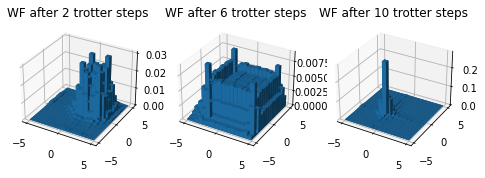

In [8]:
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

ax1.bar3d(x, y, np.zeros_like(wfs_all[opt_len-1][2]), width, depth, wfs_all[opt_len-1][2], shade=True)
ax1.set_title('WF after 2 trotter steps')

ax2.bar3d(x, y, np.zeros_like(wfs_all[opt_len-1][6]), width, depth, wfs_all[opt_len-1][6], shade=True)
ax2.set_title('WF after 6 trotter steps')

ax3.bar3d(x, y, np.zeros_like(wfs_all[opt_len-1][10]), width, depth, wfs_all[opt_len-1][10], shade=True)
ax3.set_title('WF after 10 trotter steps')

plt.show()

<IPython.core.display.Javascript object>


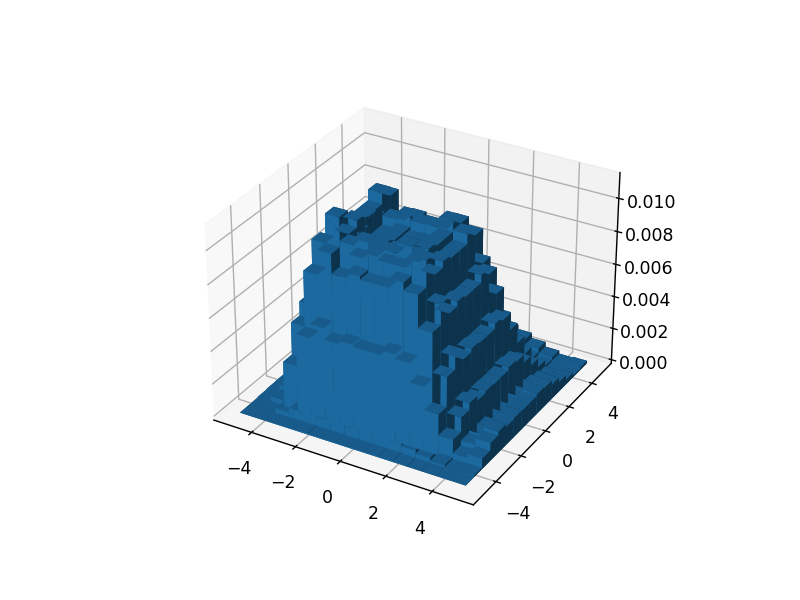

In [15]:
def update_bars(num):
    ax.cla()
    ax.bar3d(x, y, z, width, depth, wfs_all[opt_len-1][num], shade=True)

fig2 = plt.figure(2)
ax = fig2.add_subplot(111, projection='3d')

ax.bar3d(x, y, z, width, depth, 0, shade=True)

wf_ani = animation.FuncAnimation(fig=fig2, func=update_bars, frames=range(len(wfs_all[opt_len-1])), init_func=None, fargs=None, interval=500, blit=False)

plt.show()